In [40]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely
import math

In [41]:
# Load the GeoJSON file
file_path = '../data/bicycle_lanes/CARRIL_BICI.geojson'
bike_lanes: gpd.GeoDataFrame = gpd.read_file(file_path)

# Display basic information about the dataset
print(f"Dataset shape: {bike_lanes.shape}")
bike_lanes.head()

Dataset shape: (429, 5)


,CODI_CAPA,CODI_SUBCAPA,ID,TOOLTIP,geometry
0,K023,K06,GL3397302,Carril bici unidireccional Enllaç Provença - S...,"LINESTRING (2.17334 41.40359, 2.17334 41.4034)"
1,K023,K06,GL3397303,Carril bici unidireccional Connexió Meridiana ...,"LINESTRING (2.18689 41.40888, 2.18683 41.40873)"
2,K023,K06,GL3397304,Carril bici unidireccional av Diagonal - nada ...,"LINESTRING (2.16666 41.39814, 2.16908 41.39876..."
3,K023,K06,GL3397305,Carril bici unidireccional Carrer de Nàpols,"LINESTRING (2.17436 41.39923, 2.17767 41.39671)"
4,K023,K06,GL3397306,Carril bici unidireccional Carrer de Castillejos,"LINESTRING (2.18541 41.40115, 2.18541 41.40114..."


In [42]:
# Display dataset information
bike_lanes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   CODI_CAPA     429 non-null    object  
 1   CODI_SUBCAPA  429 non-null    object  
 2   ID            429 non-null    object  
 3   TOOLTIP       429 non-null    object  
 4   geometry      429 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 16.9+ KB


In [43]:
# Check for missing values
missing_values = bike_lanes.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
CODI_CAPA       0
CODI_SUBCAPA    0
ID              0
TOOLTIP         0
geometry        0
dtype: int64


In [44]:
# Basic statistics for the dataset
bike_lanes.describe()

,CODI_CAPA,CODI_SUBCAPA,ID,TOOLTIP,geometry
count,429,429,429,429,429
unique,1,1,429,417,429
top,K023,K06,GL3397302,Carril bici bidireccional carrer Alaba,LINESTRING (2.1733425554533223 41.403594586433...
freq,429,429,1,3,1


In [45]:
# Exploring the geometry column
print("Geometry types in the dataset:")
print(bike_lanes.geometry.type.value_counts())

Geometry types in the dataset:
LineString    429
Name: count, dtype: int64


In [46]:
# Calculate and add length of each bike lane - FIXED
# First, identify the appropriate UTM zone for Barcelona (UTM Zone 31N, EPSG:32631)
bike_lanes_projected = bike_lanes.to_crs(epsg=32631)  # Project to UTM Zone 31N

# Calculate length in meters directly (no need for conversion factor)
bike_lanes['length_meters'] = bike_lanes_projected.geometry.length

# Display summary statistics for bike lane lengths
print("Bike lane length statistics (meters):")
print(bike_lanes['length_meters'].describe())

Bike lane length statistics (meters):
count     429.000000
mean      544.559054
std       637.609960
min         5.390915
25%       111.792831
50%       338.525418
75%       718.357049
max      4032.409962
Name: length_meters, dtype: float64


In [47]:
# Find the longest and shortest bike lanes
longest_lane = bike_lanes.loc[bike_lanes['length_meters'].idxmax()]
shortest_lane = bike_lanes.loc[bike_lanes['length_meters'].idxmin()]

print(f"Longest bike lane: {longest_lane['length_meters']:.2f} meters")
if 'TOOLTIP' in longest_lane:
    print(f"Description: {longest_lane['TOOLTIP']}")

print(f"Shortest bike lane: {shortest_lane['length_meters']:.2f} meters")
if 'TOOLTIP' in shortest_lane:
    print(f"Description: {shortest_lane['TOOLTIP']}")

Longest bike lane: 4032.41 meters
Description: Carril bici unidireccional València - tram 2
Shortest bike lane: 5.39 meters
Description: Carril bici bidireccional Enllaç Manso - Urgell


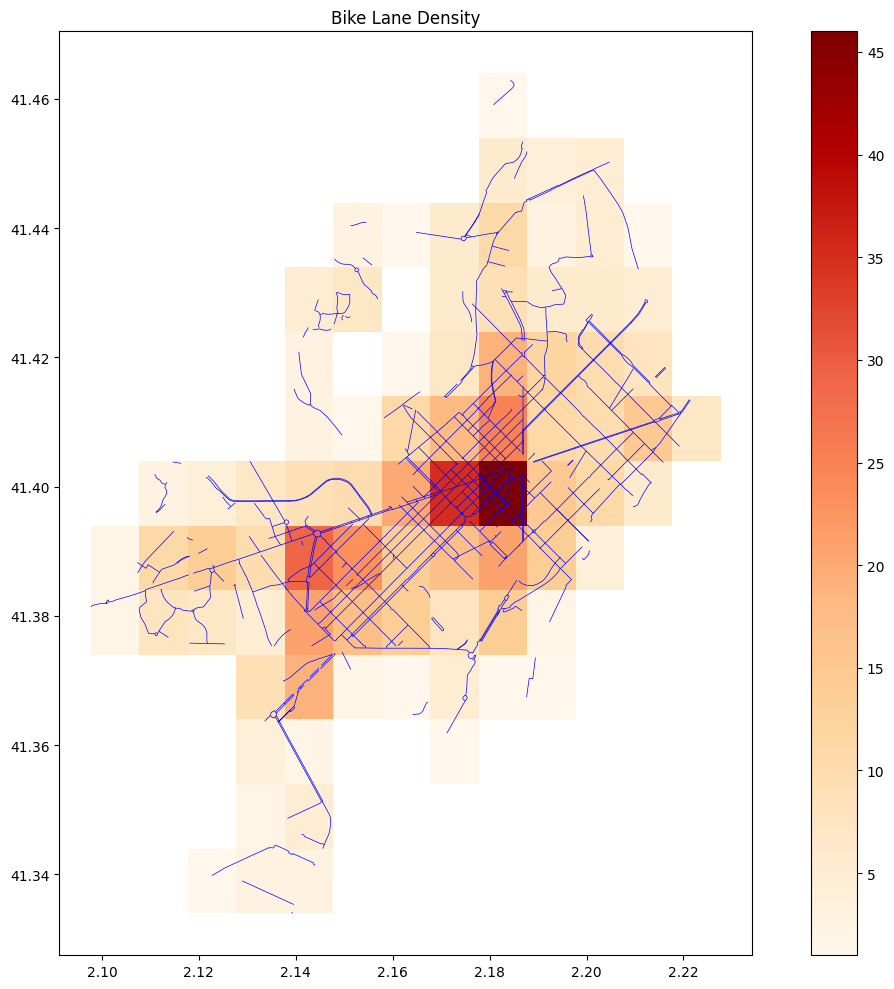

In [48]:
# Spatial density analysis
from shapely.geometry import box

# Create a grid over the area
bounds = bike_lanes.total_bounds
xmin, ymin, xmax, ymax = bounds
cell_size = 0.01  # Cell size in degrees (adjust as needed)

# Create grid cells
grid_cells = []
for x0 in np.arange(xmin, xmax, cell_size):
    for y0 in np.arange(ymin, ymax, cell_size):
        cell = box(x0, y0, x0+cell_size, y0+cell_size)
        grid_cells.append(cell)

# Create GeoDataFrame from grid
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=bike_lanes.crs)

# Count intersections with bike lanes
grid['bike_lane_count'] = grid.apply(
    lambda row: bike_lanes.intersects(row.geometry).sum(),
    axis=1
)

# Filter cells with at least one bike lane
grid = grid[grid['bike_lane_count'] > 0]

# Plot density map
fig, ax = plt.subplots(figsize=(12, 10))
grid.plot(column='bike_lane_count', ax=ax, legend=True, cmap='OrRd')
bike_lanes.plot(ax=ax, color='blue', linewidth=0.5)
plt.title('Bike Lane Density')
plt.tight_layout()
plt.show()

In [49]:
# Connectivity analysis
# Calculate start and end points for each lane
bike_lanes['start_point'] = bike_lanes.geometry.apply(lambda x: shapely.geometry.Point(x.coords[0]))
bike_lanes['end_point'] = bike_lanes.geometry.apply(lambda x: shapely.geometry.Point(x.coords[-1]))

# Find isolated segments (no connection with other bike lanes)
# Buffer endpoints by 10 meters to check for nearby connections
bike_lanes_projected = bike_lanes.to_crs(epsg=32631)
start_buffers = gpd.GeoSeries([point.buffer(10) for point in bike_lanes_projected.start_point])
end_buffers = gpd.GeoSeries([point.buffer(10) for point in bike_lanes_projected.end_point])

# Identify isolated segments
bike_lanes['is_isolated'] = True
for i, lane in bike_lanes.iterrows():
    # Check if this lane's endpoints are near any other lane
    for j, other_lane in bike_lanes.iterrows():
        if i != j:
            if (start_buffers.iloc[i].intersects(other_lane.geometry) or 
                end_buffers.iloc[i].intersects(other_lane.geometry)):
                bike_lanes.at[i, 'is_isolated'] = False
                break

In [50]:
# Complexity metrics
# Calculate number of points in each lane
bike_lanes['num_points'] = bike_lanes.geometry.apply(lambda x: len(x.coords))

# Calculate sinuosity (ratio of actual length to straight line distance)
def calculate_sinuosity(line):
    if len(line.coords) < 2:
        return 1.0
    start = shapely.geometry.Point(line.coords[0])
    end = shapely.geometry.Point(line.coords[-1])
    straight_dist = start.distance(end)
    if straight_dist == 0:
        return 1.0  # Avoid division by zero for loops
    return line.length / straight_dist

bike_lanes_projected = bike_lanes.to_crs(epsg=32631)
bike_lanes['sinuosity'] = bike_lanes_projected.geometry.apply(calculate_sinuosity)


In [51]:
# Directional analysis
# Calculate bearing (direction) of each bike lane
def calculate_bearing(line):
    if len(line.coords) < 2:
        return None
    start = line.coords[0]
    end = line.coords[-1]
    # Calculate bearing (0 = north, 90 = east, etc.)
    bearing = math.degrees(math.atan2(end[0] - start[0], end[1] - start[1]))
    # Normalize to 0-360
    return (bearing + 360) % 360

bike_lanes['bearing'] = bike_lanes.geometry.apply(calculate_bearing)

# Add cardinal direction (N, NE, E, etc.)
def bearing_to_cardinal(bearing):
    if bearing is None:
        return None
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    return directions[round(bearing / 45)]

bike_lanes['direction'] = bike_lanes['bearing'].apply(bearing_to_cardinal)


In [52]:
# Intersection analysis with other bike lanes
def count_intersections(geometry, all_geometries):
    count = 0
    for other_geom in all_geometries:
        if geometry.intersects(other_geom) and not geometry.equals(other_geom):
            count += 1
    return count

all_geometries = bike_lanes.geometry.tolist()
bike_lanes['intersection_count'] = bike_lanes.geometry.apply(lambda x: count_intersections(x, all_geometries))


In [53]:
# Create choropleth map of bike lane density by district
# (If we had district boundaries - example of what we could do)
# Count lanes per district
# districts['bike_lane_count'] = districts.apply(
#     lambda row: bike_lanes.intersects(row.geometry).sum(), axis=1
# )
# districts['bike_lane_density'] = districts['bike_lane_count'] / districts.area


In [54]:
# Calculate distance to city center
# Define a central point (e.g., Plaça Catalunya)
center_point = shapely.geometry.Point(2.17, 41.387)
# Project to UTM
center_point_projected = gpd.GeoSeries([center_point], crs=bike_lanes.crs).to_crs(epsg=32631)[0]
# Calculate distance from each bike lane to center
bike_lanes['dist_to_center'] = bike_lanes_projected.geometry.apply(
    lambda x: center_point_projected.distance(shapely.geometry.Point(x.centroid))
)

In [55]:
# Distribution analysis
# Create bins based on distance from center
bike_lanes['dist_bin'] = pd.cut(bike_lanes['dist_to_center'], 
                               bins=[0, 1000, 2000, 3000, 4000, 5000, float('inf')],
                               labels=['0-1km', '1-2km', '2-3km', '3-4km', '4-5km', '5km+'])

# Summarize by distance bin
dist_summary = bike_lanes.groupby('dist_bin').agg({
    'length_meters': ['sum', 'mean', 'count']
})

C:\Users\bruna\AppData\Local\Temp\ipykernel_16492\2428459898.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_summary = bike_lanes.groupby('dist_bin').agg({


In [56]:
dist_summary

length_meters                  
                   sum        mean count
dist_bin                                
0-1km     18574.203562  773.925148    24
1-2km     56902.132019  458.888161   124
2-3km     55230.087991  541.471451   102
3-4km     38867.839620  616.949835    63
4-5km     38804.805367  625.883958    62
5km+      25236.765788  467.347515    54

In [57]:
# Basic statistics for the dataset
bike_lanes.describe(include='all')

,CODI_CAPA,CODI_SUBCAPA,ID,TOOLTIP,geometry,length_meters,start_point,end_point,is_isolated,num_points,sinuosity,bearing,direction,intersection_count,dist_to_center,dist_bin
count,429,429,429,429,429,429.000000,429,429,429,429.000000,4.290000e+02,429.000000,429,429.000000,429.000000,429
unique,1,1,429,417,429,NaN,425,426,1,NaN,NaN,NaN,8,NaN,NaN,6
top,K023,K06,GL3397302,Carril bici bidireccional carrer Alaba,LINESTRING (2.1733425554533223 41.403594586433...,NaN,POINT (2.1956959220813315 41.38811490224517),POINT (2.201220929612744 41.41477548471587),False,NaN,NaN,NaN,SW,NaN,NaN,1-2km
freq,429,429,1,3,1,NaN,2,2,429,NaN,NaN,NaN,86,NaN,NaN,124
mean,NaN,NaN,NaN,NaN,NaN,544.559054,NaN,NaN,NaN,20.328671,2.176714e+04,171.073623,NaN,1.892774,2960.454239,NaN
std,NaN,NaN,NaN,NaN,NaN,637.609960,NaN,NaN,NaN,94.068436,4.505039e+05,97.258954,NaN,2.434693,1618.565244,NaN
min,NaN,NaN,NaN,NaN,NaN,5.390915,NaN,NaN,NaN,2.000000,1.000000e+00,0.000000,NaN,0.000000,289.113956,NaN
25%,NaN,NaN,NaN,NaN,NaN,111.792831,NaN,NaN,NaN,3.000000,1.000003e+00,76.409690,NaN,0.000000,1636.823909,NaN
50%,NaN,NaN,NaN,NaN,NaN,338.525418,NaN,NaN,NaN,6.000000,1.004185e+00,179.255749,NaN,1.000000,2522.771231,NaN
75%,NaN,NaN,NaN,NaN,NaN,718.357049,NaN,NaN,NaN,13.000000,1.039927e+00,245.400299,NaN,2.000000,4124.298071,NaN


In [58]:
import folium
from folium.plugins import MeasureControl, MiniMap, Search, LocateControl
import pandas as pd
import numpy as np

center = [41.39, 2.17]  # Barcelona coordinates
m = folium.Map(location=center, zoom_start=13, 
               tiles='CartoDB positron',
               control_scale=True)

# Add alternative basemaps with proper attribution
folium.TileLayer(
    'CartoDB dark_matter',
    name='Dark Mode',
    attr='&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> &copy; <a href="http://cartodb.com/attributions">CartoDB</a>'
).add_to(m)

folium.TileLayer(
    'OpenStreetMap',
    name='OpenStreetMap',
    attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
).add_to(m)

folium.TileLayer(
    'Stamen Terrain',
    name='Terrain',
    attr='Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.'
).add_to(m)

# Define a generic color function based on available data
def get_color(row):
    # Priority order for coloring (most meaningful first)
    if 'is_isolated' in row and row['is_isolated']:
        return 'red'  # Isolated segments are always red
    
    elif 'network_id' in row:
        # Use a hash of the network_id to generate a consistent color
        network_hash = hash(str(row['network_id'])) % 5
        colors = ['blue', 'green', 'purple', 'orange', 'darkblue']
        return colors[network_hash]
    
    elif 'CODI_SUBCAPA' in row:
        # Use a hash of the subcategory for consistent coloring
        subcapa_hash = hash(str(row['CODI_SUBCAPA'])) % 5
        colors = ['blue', 'green', 'purple', 'orange', 'darkblue']
        return colors[subcapa_hash]
    
    return 'blue'  # Default color

# Generate tooltips dynamically with all available metrics
for _, row in bike_lanes.iterrows():
    # Convert the coordinates from (lon, lat) to (lat, lon) as required by folium
    coords = [(y, x) for x, y in list(row.geometry.coords)]
    
    # Start with basic tooltip
    tooltip = "<div style='max-width: 300px;'>"
    
    # Always include ID if available (usually the most important identifier)
    if 'ID' in row:
        tooltip += f"<strong>ID:</strong> {row['ID']}<br>"
    
    # Add description/tooltip if available (gives context)
    if 'TOOLTIP' in row and isinstance(row['TOOLTIP'], str):
        tooltip += f"<strong>Description:</strong> {row['TOOLTIP']}<br>"
    
    # Add all other attributes in a generic way
    skipped_cols = ['geometry', 'ID', 'TOOLTIP', 'start_point', 'end_point']
    
    # Group metrics by categories
    geometric_metrics = ['length_meters', 'sinuosity', 'num_points']
    network_metrics = ['is_isolated', 'network_id', 'intersection_count']
    direction_metrics = ['bearing', 'direction']
    location_metrics = ['dist_to_center', 'dist_bin']
    
    # Process all columns dynamically
    for col in row.index:
        if col in skipped_cols:
            continue
        
        # Format based on data type
        if pd.isna(row[col]):
            continue
            
        value = row[col]
        
        # Format numeric values appropriately
        if isinstance(value, (int, float, np.number)):
            if col == 'length_meters':
                formatted_value = f"{value:.1f} m"
            elif col == 'dist_to_center' and value > 1000:
                formatted_value = f"{value/1000:.2f} km"
            elif col == 'sinuosity':
                formatted_value = f"{value:.2f}"
            elif col == 'bearing':
                formatted_value = f"{value:.1f}°"
            else:
                formatted_value = f"{value}"
        elif isinstance(value, bool):
            formatted_value = 'Yes' if value else 'No'
        else:
            formatted_value = str(value)
        
        # Convert snake_case to Title Case
        display_name = ' '.join(word.capitalize() for word in col.split('_'))
        tooltip += f"<strong>{display_name}:</strong> {formatted_value}<br>"
    
    tooltip += "</div>"
    
    # Style based on calculated metrics - set defaults first
    weight = 3
    opacity = 0.7
    
    # Adjust weight based on properties if available
    if 'sinuosity' in row:
        if row['sinuosity'] > 2:
            weight = 5  # Very winding paths
        elif row['sinuosity'] > 1.5:
            weight = 4  # Moderately winding
    
    # Adjust opacity based on properties if available
    if 'is_isolated' in row and row['is_isolated']:
        opacity = 0.9  # Isolated segments
    elif 'intersection_count' in row and row['intersection_count'] > 3:
        opacity = 0.85  # High-intersection segments
    
    # Add the line to the map
    folium.PolyLine(
        coords,
        color=get_color(row),
        weight=weight,
        opacity=opacity,
        tooltip=tooltip
    ).add_to(m)

# Add layer control panel
folium.LayerControl().add_to(m)

# Add useful plugins
MeasureControl().add_to(m)
LocateControl().add_to(m)
MiniMap().add_to(m)

# Add fullscreen option
fullscreen_html = '''
<script>
document.addEventListener('keydown', function(e) {
    if (e.key === 'f') {
        if (!document.fullscreenElement) {
            document.documentElement.requestFullscreen();
        } else {
            if (document.exitFullscreen) {
                document.exitFullscreen();
            }
        }
    }
});
</script>
<div style="position: fixed; 
            bottom: 10px; right: 10px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px;
            padding: 5px;
            border-radius: 5px;
            cursor: pointer;">
    <span onclick="if (!document.fullscreenElement) { document.documentElement.requestFullscreen(); } else { if (document.exitFullscreen) { document.exitFullscreen(); }}">⛶ Fullscreen (or press 'f')</span>
</div>
'''
m.get_root().html.add_child(folium.Element(fullscreen_html))

# Add a title
title_html = '''
<div style="position: fixed; 
            top: 10px; left: 50px; width: 300px; height: 30px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:16px; font-weight: bold;
            padding: 5px;
            border-radius: 5px;">
            Barcelona Bike Lane Network Analysis
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Dynamically generate legend based on what coloring scheme is used
legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px;
            padding: 10px;
            border-radius: 5px;">
    <p><strong>Map Legend</strong></p>
'''

# Add legend elements based on what metrics are available in the dataset
if 'is_isolated' in bike_lanes.columns:
    legend_html += '''
    <p><i style="background: red; width: 15px; height: 15px; display: inline-block;"></i> Isolated Segments</p>
    '''

if 'network_id' in bike_lanes.columns:
    legend_html += '''
    <p>
        <i style="background: blue; width: 15px; height: 15px; display: inline-block;"></i> Network 1<br>
        <i style="background: green; width: 15px; height: 15px; display: inline-block;"></i> Network 2<br>
        <i style="background: purple; width: 15px; height: 15px; display: inline-block;"></i> Network 3<br>
        <i style="background: orange; width: 15px; height: 15px; display: inline-block;"></i> Network 4<br>
        <i style="background: darkblue; width: 15px; height: 15px; display: inline-block;"></i> Network 5
    </p>
    '''
elif 'CODI_SUBCAPA' in bike_lanes.columns:
    # Find unique subcategories
    subcategories = bike_lanes['CODI_SUBCAPA'].unique()
    legend_html += '<p>'
    for i, subcategory in enumerate(subcategories[:5]):  # Limit to first 5
        color_idx = hash(str(subcategory)) % 5
        colors = ['blue', 'green', 'purple', 'orange', 'darkblue']
        color = colors[color_idx]
        legend_html += f'<i style="background: {color}; width: 15px; height: 15px; display: inline-block;"></i> {subcategory}<br>'
    legend_html += '</p>'

legend_html += '''
    <p><small>Thicker lines indicate more winding paths</small></p>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Generate info panel dynamically based on available metrics
info_html = '''
<div style="position: fixed; 
            top: 50px; right: 10px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px;
            padding: 10px;
            border-radius: 5px;
            max-width: 250px;">
    <p><strong>Available Metrics:</strong></p>
    <ul style="padding-left: 15px; margin-top: 5px;">
'''

# Add descriptions for metrics that exist in our dataset
metric_descriptions = {
    'length_meters': 'Length of bike lane in meters',
    'sinuosity': 'How winding the path is (1.0 = straight line)',
    'direction': 'Cardinal direction of the path',
    'bearing': 'Angle in degrees (0° = North)',
    'is_isolated': 'Whether path connects to other bike lanes',
    'network_id': 'Connected group of bike lanes',
    'intersection_count': 'Number of crossings with other bike lanes',
    'dist_to_center': 'Distance to city center in meters',
    'num_points': 'Number of coordinate points in the path'
}

for col in bike_lanes.columns:
    if col in metric_descriptions:
        info_html += f'<li><strong>{col}:</strong> {metric_descriptions[col]}</li>'

info_html += '''
    </ul>
    <p style="margin-top: 5px;"><small>Hover over lanes for details</small></p>
</div>
'''
m.get_root().html.add_child(folium.Element(info_html))

m.save('../data/bicycle_lanes/barcelona_bike_lanes_interactive.html')